# Raspberry Turk Robotic Arm

## Introduction

The Raspberry Turk uses a robotic arm ([SCARA](https://en.wikipedia.org/wiki/SCARA)) to pick up and move chess pieces. The arm consists of two links, whose rotation is each controlled by a separate servo. This allows it to move freely in the X-Y direction while remaining rigid in the Z direction. There is a third servo that controls the vertical motion at the end of the arm.

![](assets/realarm.png)

In order to move pieces, the robot needs to be able to adjust the servos rotation $(s_1, s_2)$ to accurately move the arm to any given $x, y$ coordinate on the board.

$s_1, s_2 = g(x, y)$

**Our goal in this notebook is to create this function $g(x, y)$.**

## Working Backwards

We'll eventualy get to $g(x, y)$, but to get there we need to work backwards. To begin, let's first formalize what we know.

![](assets/slice1.png)

The arm consists of two links of length $l_i$. Since we know the lengths of the links, we can come up with an equation to determine $x, y$ given their angles $(\theta_i)$.

$$f_x(\theta_1, \theta_2) = x_{offset} + cos(\theta_1) \cdot l_1 + cos(\theta_1 + \theta_2) \cdot l_2$$
$$f_y(\theta_1, \theta_2) = y_{offset} + sin(\theta_1) \cdot l_1 + sin(\theta_1 + \theta_2) \cdot l_2$$

Now, in order to derive $\theta_i$ we need to learn more about the servo and how it's attached to the arm.

![](assets/dx_series_goal.png)
<center>[_Diagram from Robotis Dynamixel AX-12A support manual_](http://support.robotis.com/en/product/dynamixel/ax_series/dxl_ax_actuator.htm#Actuator_Address_1E)</center>

You can adjust the rotation of the servo by setting the goal position address in the RAM of the servo. The goal position address is a number between 0 and 1023 (10 bit value) that maps to a 0° to 300° rotation. This equates to an accuracy of 0.29° per unit change in value (not bad!).

![](assets/servo.jpg)

The servo is attached to a pinion gear which rotates a larger gear that the link of the arm is directly attached to. The pinion gear has 32 teeth and the larger gear has 76 teeth. This gives us a gear ratio of $\frac{76}{32}$ or $2.375 : 1$. From now on we'll refer to this gear ratio as $\phi$. Additionally, we must account of the rotational offset of the link when the servo goal position has a value of $0$. We'll call this rotational offset $\theta'_i$. Given this, we can how calculate $\theta_i$ given the goal position ($s_i$) of the servo.

$$\theta_i(s_i) = \theta'_i + \frac{1023-s_i}{1023}\cdot 300°\cdot \phi$$

Now, we have everything we need to convert any $s_1, s_2$ to an $x, y$.

$$f_x(s_1, s_2) = x_{offset} + \cos(\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_1)\cdot l_1 + \cos((\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_1) + (\frac{1023-s_2}{1023}\cdot 300°\cdot \phi + \theta'_2)) \cdot l_2 \\[10pt]$$
$$f_y(s_1, s_2) = y_{offset} + \sin(\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_{s_1})\cdot l_1 + \sin((\frac{1023-s_1}{1023}\cdot 300°\cdot \phi + \theta'_1) + (\frac{1023-s_2}{1023}\cdot 300°\cdot \phi + \theta'_2)) \cdot l_2$$

However, both $f_x$ and $f_y$ are assuming ideal conditions. In reality there is error introduced by inaccuracies in measurements, and unaccounted for real world effects on the system.

## INSERT Image showing error

In order to achieve better accuracy in reality we need to better understand this error component and account for it.

$$f'_x(s_1, s_2) = f_x(s_1, s_2) + \epsilon_x(s_1, s_2)$$
$$f'_y(s_1, s_2) = f_y(s_1, s_2) + \epsilon_y(s_1, s_2)$$

$f'_x$ and $f'_y$ represent the actual real world $x, y$ given any $s_1, s_2$, where $\epsilon_x$ and $\epsilon_y$ is the respective error. In a more simple form:

$$f'(s) = f(s) + \epsilon(s)$$

To achieve a $f'(s)$ that is suffienct for our purposes we need to, as accurately as possible, model $\epsilon$.

In order to model $\epsilon$ we first need to collect a sample of data points. To do this I manually moved the arm to to 81 points and recorded the real $x, y$ and the respective $s_1, s_2$. Let's begin there.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/arm_error.csv')

In [2]:
data.head()

,s1,s2,x,y
0,92,482,0.125,0.0000
1,177,1023,0.000,18.0000
2,497,386,9.000,9.0000
3,950,0,18.000,0.1875
4,674,660,18.000,18.0000


We need two new columns for $x$ and $y$ error. We can calculate this by first calulating the theoretical coordinate and then subtracting the observed coordinate.

In [3]:
dynamixel_range = 300.0
gear_ratio = 76.0 / 32.0
l_1 = 15.25
l_2 = 13.75
x_offset = 17.0
y_offset = -2.97
gripper_offset = 0.5

def f_with_theta(s, theta_prime_1, theta_prime_2):
    theta_1 = ((1023.0-s[:,0])/1023.0) * np.deg2rad(dynamixel_range / gear_ratio) + theta_prime_1
    theta_2 = ((1023.0-s[:,1])/1023.0) * np.deg2rad(dynamixel_range / gear_ratio) + theta_prime_2
    x = x_offset + np.cos(theta_1) * l_1 + np.cos(theta_1 + theta_2) * l_2 + np.cos(theta_1 + theta_2 + np.pi/2.0) * gripper_offset
    y = y_offset + np.sin(theta_1) * l_1 + np.sin(theta_1 + theta_2) * l_2 + np.sin(theta_1 + theta_2 + np.pi/2.0) * gripper_offset
    return np.array([x, y]).T

In [4]:
from sklearn.metrics import mean_squared_error
from copy import copy
from itertools import product
from scipy.optimize import brute

def mse(theta):
    xy = f_with_theta(data.values[:,0:2], theta[0], theta[1])
    return np.array([mean_squared_error(data.x, xy[:,0]), mean_squared_error(data.y, xy[:,1])]).mean()

theta_prime_1_estimate = np.deg2rad(4.0)
theta_prime_2_estimate = np.deg2rad(40.0)

def slice_for_value(value):
    inc = value * 0.2
    return slice(value - inc, value + inc)

t = brute(mse, [slice_for_value(theta_prime_1_estimate),
                slice_for_value(theta_prime_2_estimate)])


print "θ′: {}".format(np.rad2deg(t))

θ′: [  3.82714566  39.9262376 ]


In [5]:
def f(s):
    return f_with_theta(s, t[0], t[1])

In [6]:
theoretical_xy = f(data.values[:,0:2])
data["x_theory"] = theoretical_xy[:,0]
data["y_theory"] = theoretical_xy[:,1]
data["x_error"] = data.x - data.x_theory
data["y_error"] = data.y - data.y_theory

In [7]:
data.head()

,s1,s2,x,y,x_theory,y_theory,x_error,y_error
0,92,482,0.125,0.0000,0.378050,0.236596,-0.253050,-0.236596
1,177,1023,0.000,18.0000,0.263558,18.327552,-0.263558,-0.327552
2,497,386,9.000,9.0000,8.948043,8.989270,0.051957,0.010730
3,950,0,18.000,0.1875,18.112372,0.139365,-0.112372,0.048135
4,674,660,18.000,18.0000,17.901277,18.107595,0.098723,-0.107595


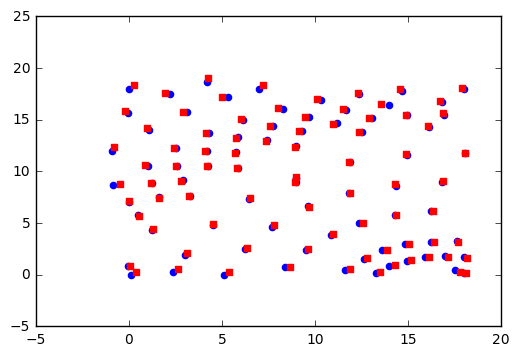

In [8]:
import matplotlib.pyplot as plt

def scatter(x, y):
    plt.scatter(data.x, data.y, color='blue')
    plt.scatter(x, y, color='red', marker=',')
    plt.show()

scatter(data.x_theory, data.y_theory)

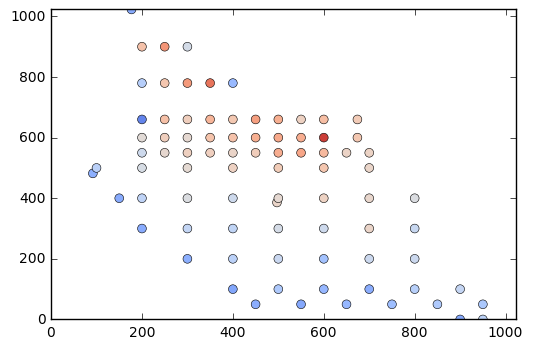

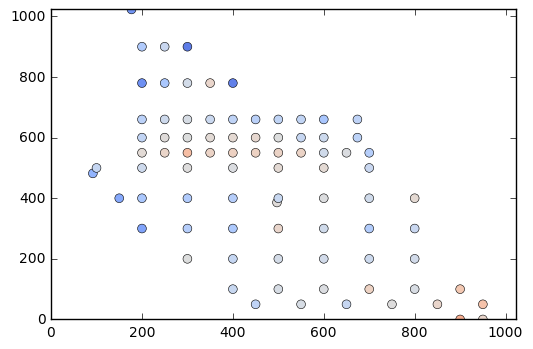

In [9]:
from matplotlib import cm
from matplotlib.colors import Normalize

plt.scatter(data.s1, data.s2, c=data.x_error, cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.4, s=40.0)
plt.xlim(0,1023)
plt.ylim(0,1023)
plt.show()
plt.scatter(data.s1, data.s2, c=data.y_error, cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.4, s=40.0)
plt.xlim(0,1023)
plt.ylim(0,1023)
plt.show()

In order to model error, we can use support vector regression.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X_train = data.values[:,0:2]
poly = PolynomialFeatures(degree=3)
X_train = poly.fit_transform(X_train)
z = data.values[:,6:8]
x_error_model = LinearRegression()
y_error_model = LinearRegression()

cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cvs_x = cross_val_score(x_error_model, X_train, y=z[:, 0], scoring='neg_mean_squared_error', cv=cv)
cvs_y = cross_val_score(y_error_model, X_train, y=z[:, 1], scoring='neg_mean_squared_error', cv=cv)
print "Cross validation error for x: {}".format(cvs_x)
print "Cross validation error for y: {}".format(cvs_y)

x_error_model.fit(X_train, z[:, 0])
y_error_model.fit(X_train, z[:, 1])

def predict_error(s):
    s = poly.fit_transform(s)
    return np.array([x_error_model.predict(s), y_error_model.predict(s)]).T

Cross validation error for x: [-0.01337804 -0.01384453 -0.00966184]
Cross validation error for y: [-0.00928625 -0.0084753  -0.0051186 ]


We can plot the `predict_error` function and compare them to the real error plots.

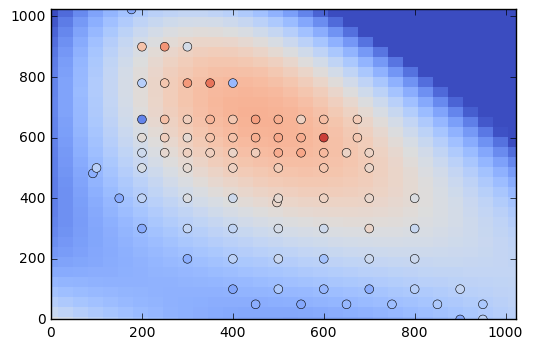

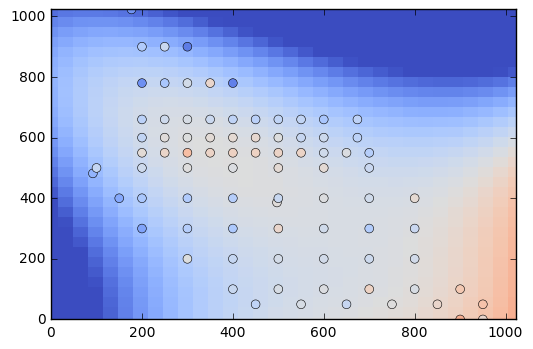

In [11]:
s_plot = np.array(list(product(np.linspace(0.0, 1023.0, 32), np.linspace(0.0, 1023.0, 32))))
predicted_error = predict_error(s_plot)
x_error_predicted = predicted_error[:,0]
y_error_predicted = predicted_error[:,1]

plt.scatter(s_plot[:,0], s_plot[:,1], c=x_error_predicted, marker=',', cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.0, s=120.0)
plt.scatter(data.s1, data.s2, c=data.x_error, cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.4, s=40.0)
plt.xlim(0,1023)
plt.ylim(0,1023)
plt.show()

plt.scatter(s_plot[:,0], s_plot[:,1], c=y_error_predicted, marker=',',cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.0, s=120.0)
plt.scatter(data.s1, data.s2, c=data.y_error, cmap=cm.coolwarm, norm=Normalize(-0.5, 0.5), linewidth=0.4, s=40.0)
plt.xlim(0,1023)
plt.ylim(0,1023)
plt.show()

Using the `predict_error` function, let's get create the function we set out to create, $f'(s)$.

In [12]:
def f_prime(s):
    return f(s) + predict_error(s)

To visualize the difference $f'(s)$ makes, we can, once again, plot the <span style="color:red;">predicted $x,y$</span> on top of the <span style="color:blue;">real $x,y$</span> for each given $s_1,s_2$.

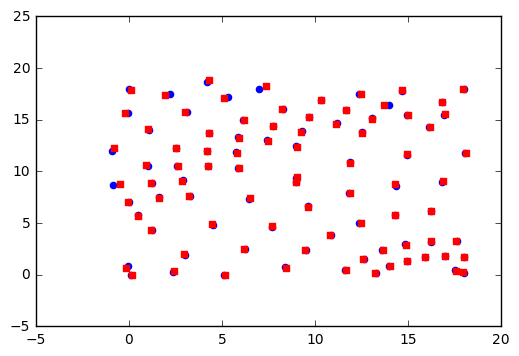

In [13]:
xy_theoretical_with_error = f_prime(data.values[:,0:2])
data['x_theory_with_error'] = xy_theoretical_with_error[:,0]
data['y_theory_with_error'] = xy_theoretical_with_error[:,1]

scatter(data.x_theory_with_error, data.y_theory_with_error)

Now that we have a working $f'(s)$, we can set out to accomplish our original goal, to create $g(x, y)$. The function $f'$ takes a $s_1, s_2$ and returns $x, y$. The function $g$ takes $x, y$ and returns $s_1, s_2$. In order to find $g$, we just need to invert $f'$! But $f'$ doesn't invert easily and we actually don't need $g$ to work over all values of $s_1,s_2$–only when $s_1,s_2 \in \{0, 1, 2, ..., 1023\}$. So instead, let's solve for every possible $s_1,s_2$ combination, and then create a [lookup tree](https://en.wikipedia.org/wiki/K-d_tree) with the results. We can the query the lookup tree to find the closest $s_1,s_2$ for any given point $x,y$.

In [14]:
from itertools import product

srange = np.array(list(product(range(1024), range(1024))))
pts = f_prime(srange)

In [15]:
from sklearn.neighbors import KDTree
tree = KDTree(pts, metric='euclidean')

In [16]:
def g(pt):
    pt = np.array(pt).reshape(1, -1)
    return srange[tree.query(pt, return_distance=False)[0]][0]

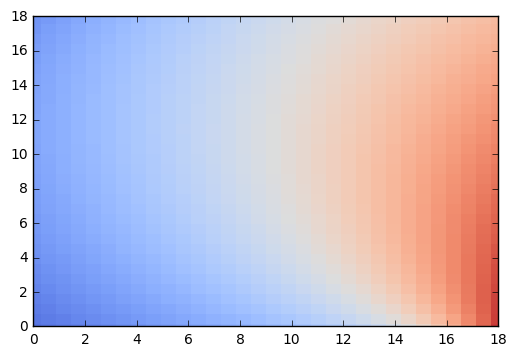

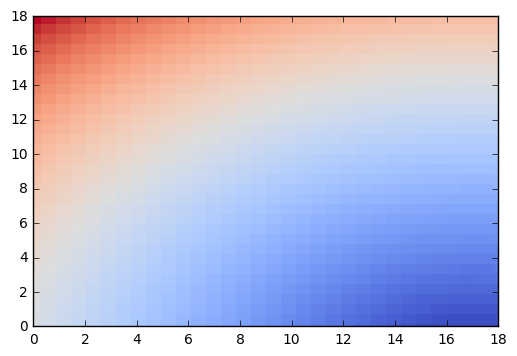

In [17]:
xy_plot = np.array(list(product(np.linspace(0.0, 18.0, 32), np.linspace(0.0, 18.0, 32))))
projected_s = np.zeros(xy_plot.shape)
for i in range(xy_plot.shape[0]):
    projected_s[i,:] = g(xy_plot[i,:])
    

plt.scatter(xy_plot[:,0], xy_plot[:,1], c=projected_s[:,0], marker=',', cmap=cm.coolwarm, norm=Normalize(0, 1023), linewidth=0.0, s=120.0)
plt.xlim(0,18)
plt.ylim(0,18)
plt.show()

plt.scatter(xy_plot[:,0], xy_plot[:,1], c=projected_s[:,1], marker=',', cmap=cm.coolwarm, norm=Normalize(0, 1023), linewidth=0.0, s=120.0)
plt.xlim(0,18)
plt.ylim(0,18)
plt.show()

In [18]:
import os
import sys
import platform
import raspberryturk_import
from raspberryturk.core import motion
import pickle

fn = "move.{}.kdtree".format(platform.machine())
path = os.path.join(os.path.dirname(os.path.abspath(motion.__file__)), fn)
with open(path, 'wb') as f:
    pickle.dump(tree, f)